## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [1]:
import import_ipynb

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *
from tools.Graphical_Tools import *
from tools.Analysis_Tools import *

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Graphical_Tools.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Analysis_Tools.ipynb


In [2]:
# Are  Midline and Edge already define in an excel file?
# Cyril's Note: For Schmidtea it's probably a better to perform a manual definition of the edge of the worm:
#         The segmentation is performed with the DIC 10x. As consequences:
#                 -> The edge of the worm where there is no centriole is included in the mask. In the Dev Cell, 2019, this zone was not taken into consideration
#                 -> It's always better (if possible) to use the 100x objective to draw the edge: there is chromatic aberration (not compensated so far) between 10x and 100x leading to mis calculation of the distance.
Load_Mid_and_Edge = True

# Are you just testing the angle compensation?
Test_Angle_Compensation = True

In [3]:
# Load Midline and Edge coordinates from a 'classical' excel file
if Load_Mid_and_Edge:
    path = './data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm'

    db = get_xls_values(path)

    x_mid = db['worm_midline']['x']
    y_mid = db['worm_midline']['y']
    x_edg = db['worm_edge']['x']
    y_edg = db['worm_edge']['y']

    newY_mid, newY_edg = [], []
    for y in y_mid:
        newY_mid.append(-y)

    for y in y_edg:
        newY_edg.append(-y)
        
    print('Midline and Edge loaded')
    
    worm = [x_mid, newY_mid, x_edg, newY_edg ]

# Automatic characterization of the midline and the edge
else:
    print('Midline and Edge computed')
    pass

########################################################################################

#+++++++++++++++++++++++++++++
# TO DO
''' Adjust the midline with the edge of the worm'''

#+++++++++++++++++++++++++++++

# Reformat a midline and Edge in a given number of segment and subsegment
midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                       x_edg, newY_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

print('Edge and Midline reformated')


#############################################################################################

# This step is usefull here to get a list of centriole already treated
if Test_Angle_Compensation:
    import xlrd  

    xls_name = "./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm"

    with xlrd.open_workbook(xls_name) as xls_file:
        # Go to appropriate sheet (index 0)
        xls_sheet = xls_file.sheet_by_index(0)

    a_list_of_centriole = []

    pixel_size = db['image_pixel_size_in_um']
    x_shift = db['image_shift']['x']
    y_shift = db['image_shift']['y']

    for row in range(xls_sheet.nrows - 7):
        if isinstance(xls_sheet.cell_value(row + 7, 3), (float, int)):
            X = xls_sheet.cell_value(row + 7, 3)/pixel_size + x_shift
            Y = -(xls_sheet.cell_value(row + 7, 4)/pixel_size + y_shift)
            angle = xls_sheet.cell_value(row + 7, 1)

            a_list_of_centriole.append(((X, Y), angle))
        
        
# Extraction of the centriole and analysis from an raw image
else:
    pass


print('Centrioles angle predicted and compensated')


####################################################################################

reoriented_centriole = []
for a_centriole in a_list_of_centriole:
    tmp_list = list(centriole_characterizator(a_centriole, midline_final))
    tmp_list.insert(1,a_centriole[0][0])
    tmp_list.insert(2,a_centriole[0][1])

    reoriented_centriole.append(tmp_list)
    
print('Centriole Dataset reformated')


File loaded: ./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm
Midline and Edge loaded
Edge and Midline reformated
Centrioles angle predicted and compensated
Centriole Dataset reformated


 Idx | Angle |Lateral| Longi   || Marker | Color
------------------------------------------------
   1 |  -34  |  0.64 |  0.48   ||   o    | darkorange
 200 |  -22  |  0.40 |  0.49   ||   o    | darkviolet
 800 |   31  |  0.68 |  0.43   ||   o    | dodgerblue
 300 |  -17  |  0.16 |  0.46   ||   o    | crimson
 400 |    8  |  0.12 |  0.47   ||   o    | magenta
 500 |   29  |  0.39 |  0.44   ||   v    | darkorange
 600 |   12  |  0.56 |  0.43   ||   v    | darkviolet
 700 |   34  |  0.69 |  0.42   ||   v    | dodgerblue


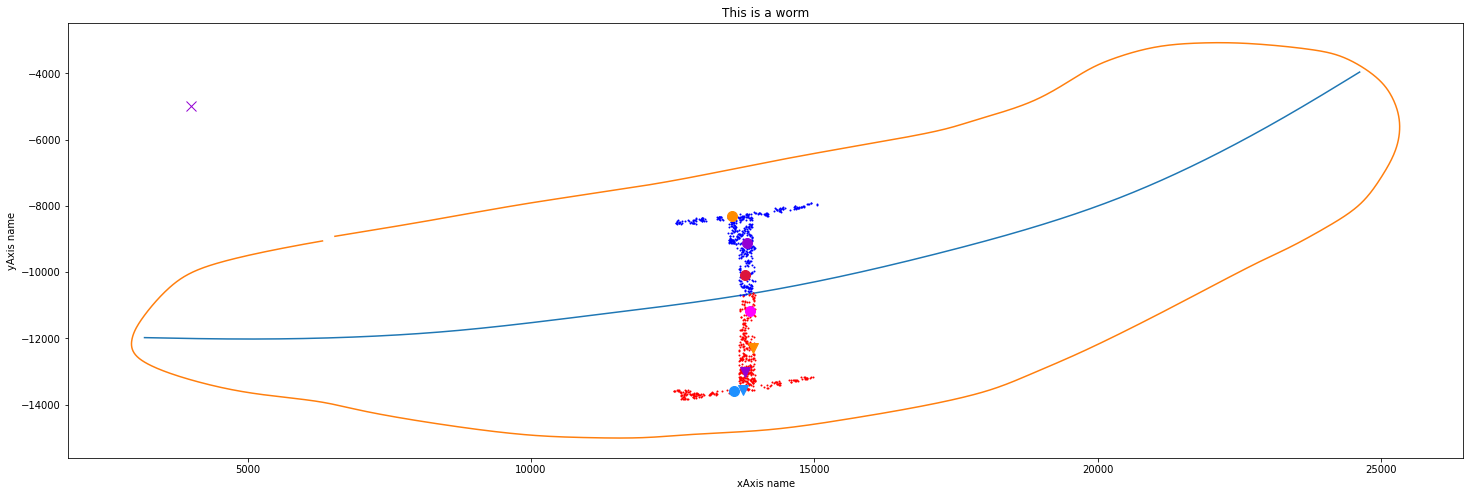

In [4]:
# Graphical Representation of the worms and the analyzed centrioles
# If you want to see some specific centrioles, add them in the list
list_of_desired_centriole = [1, 200, 800, 300, 400, 500, 600, 700]

# If you want to see the location of a specific coordinate (Write None if you don't want to see them )
X_coordinate = 4000
Y_coordinate = -5000

Worm_And_Centriole(reoriented_centriole, worm, list_of_desired_centriole, (X_coordinate, Y_coordinate))

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment
<class 'numpy.ndarray'>


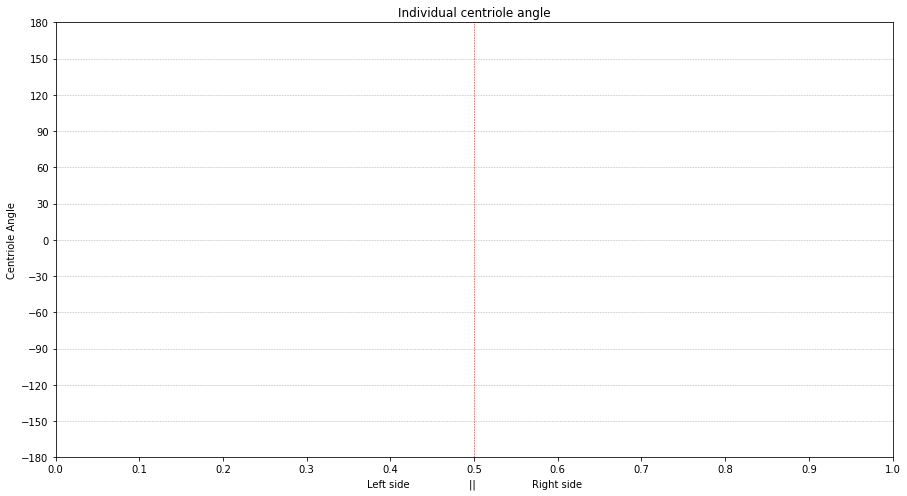

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment
<class 'numpy.ndarray'>


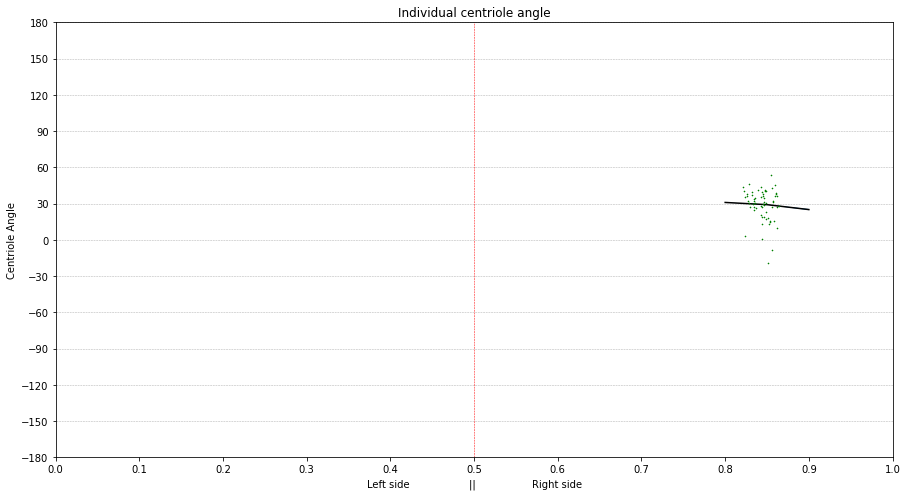

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment
<class 'numpy.ndarray'>


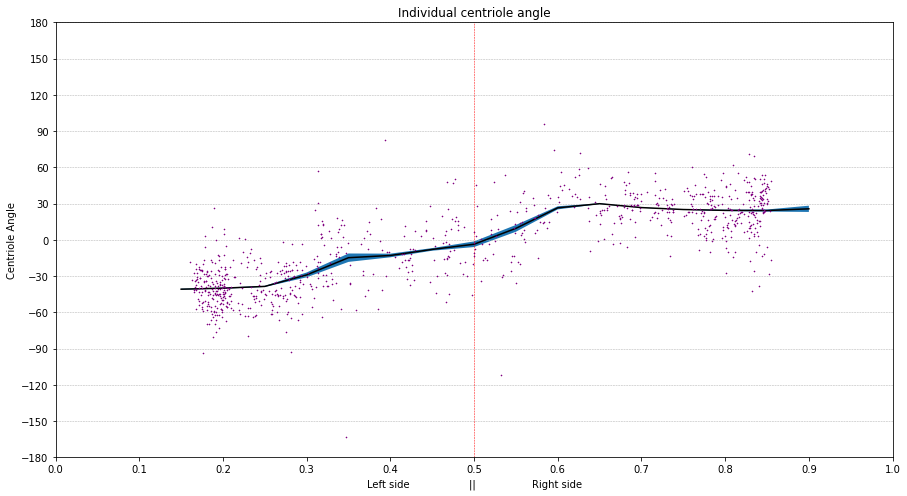

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment
<class 'numpy.ndarray'>


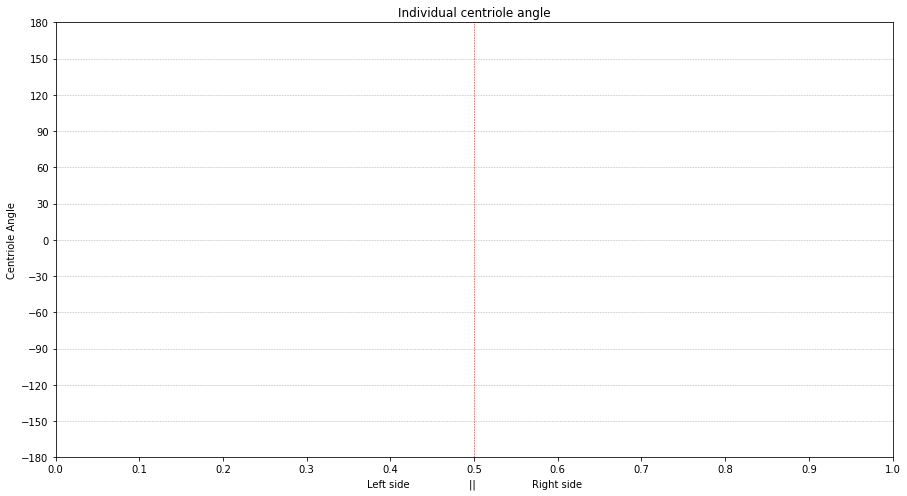

Analysis computed on 5 Antero_posterior segment and 19 Medio-lateral segment
<class 'numpy.ndarray'>


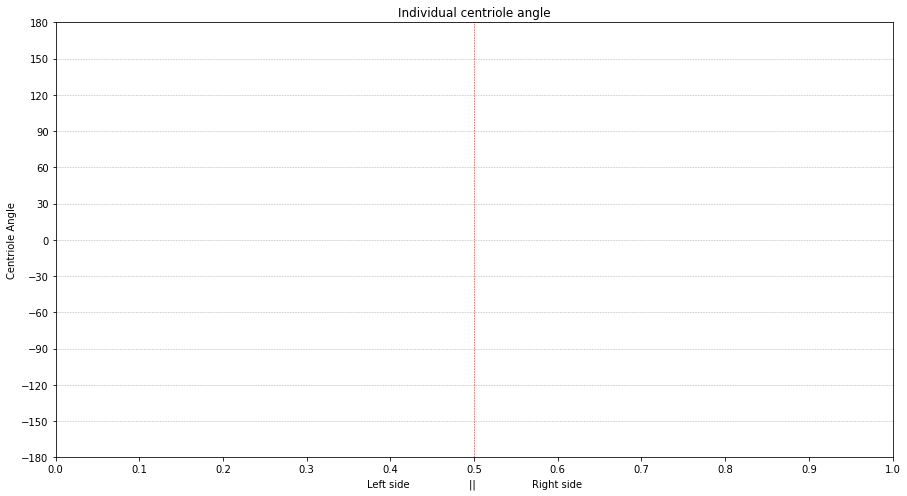

In [5]:
# Graphical representation of the results 

for i in range(5):
    print_a_antero_posterior_result(reoriented_centriole, i, n_ante_post_segment = 5, a_lat_size = 0.1, a_lat_step = 0.05)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [23]:
# Plot the mean
np.set_printoptions(precision=0)
for i in mean_angle:
    plt.plot(np.linspace(0.9, 0.1, 10), i)
    
plt.show()

NameError: name 'mean_angle' is not defined